## chapter 13
### **defining and using interfaces**

###
 **This chapter is about typing diciplines that revolve around interfaces.**

- *Duck typing*
    - python default approach to typing from the beginning
- *Goose typing*
    - the approach supported by abstract base classes (ABCs)
- *static typing*
    -  The traditional approach of statically-typed languages like C and Java; supported by the typing module and enforced by external type checkers 
- *static duck typing*
    - An approach made popular by the Go language; supported by subclasses of typ
    ing.Protocol.enforced by external type checkers.



The four typing approaches are complementary!

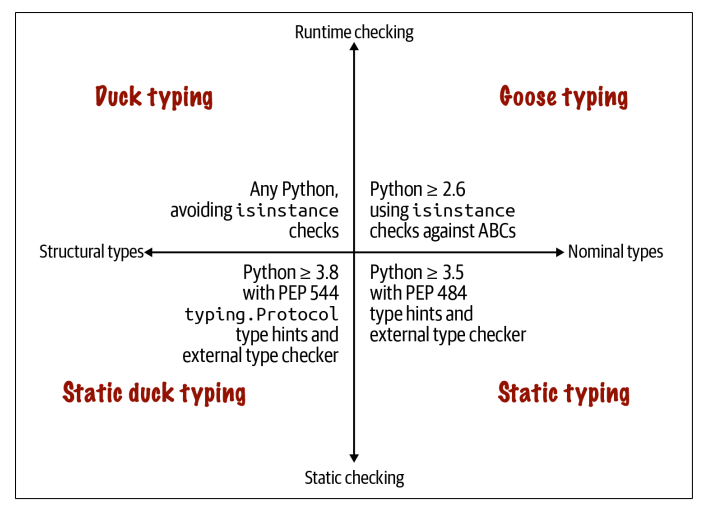

- *Top Half*:
    - runtime type checking
    - uses only python interpreter
- *Bottom Half*:
    - requires an external static type checker such as MyPy or and IDE like PyCharm.
- *Left*: 
    - typing based on the object's structure.
    <Br> which are the methods provided by the object regardless of the name of it's class or superclasses.
- *Right*:
    - depends on objecs having explicitly named types: the name of the object's class or the name of its superclasses.

**Each of these four approaches rely of `interfaces` to work, but static typing can be done _poorly_ using only concrete types instead of _interface abstractions_ like protocols and abstract base classes.**

## Two Kinds of Protocols
* A protocol is an informal interface defined only in documentation and not in the code.
* An object protocol specifies methods which an object must provide to fulfill a role.
* Implementing a full protocol may require several methods, but often it is OK to implement only part of it. 
* Consider the FrenchDeck class mentioned in the first chapter of the book.
* It implements the sequence protocol.
* The python protocol of sequences, only consists of `__len__` and `__getitem__` methods. Any class that implements these methods with the established signatures can be used as a sequnce.

* **Because it implements the `sequence protocol`, even if it is not declared anywhere in the code, it will be treated as a Sequence by Python**


Example 13-1. Partial sequence protocol implementation with `__getitem__`


In [ ]:
class Vowels:
    def __getitem__(self, i):
        return "AEIOU"[i]
v = Vowels()

#v[0]

for c in v: print(c)

-   `__getitem__` is enough to retrieve items by index, and also to support *iteration and the in operator*.
-   The `__getitem__` special method is the key to the sequence protocol.
<br>considering sequence protocol requires to support len() as well, 
in this example we can see why a protocol is an `informal interface`
since `__len__` is not implemented in Vowel class.

* Except in pages about network programming, most uses of the word “protocol” in
the Python documentation refer to these informal interfaces.

-   `Dynamic protocol:`
<br>The informal protocols Python always had.
    -   Implicit, defined by convention and described in the documentation.
    -   Also most important dynamic protocols are supported by the interpreter itself.
    - An object can implement only a part of a dynamic protocol and it will still be useful.
    -   Dynamic protocols can not be verified by the static type checkers.

-   `Static protocol:`
<br>A typing.Protocol subclass.
    -   The object must provide every method declared in the protocol class in order for the program to use it.
    -   Static protocols can be verified by the static type checkers.
    
* Both kinds of protocols share the essential characteristic that a class never needs to
declare that it supports a protocol by name, i.e., by inheritance.
    

## Programming Ducks:
* `The sequence and iterable protocols` are two of the most important in Python.
* The Python data model philosophy is to cooperate with essential dynamic protocols as much as possible.

### Python Digs Sequences:

* Figure 13-2 shows how the Sequence interface is formalized as an ABC.
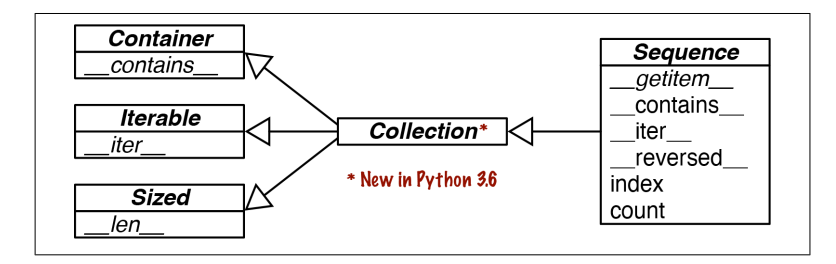

* Note that The Python
interpreter and built-in sequences like list, str, etc., do not rely on that ABC at all. This image is simply a diagram of methods a full-fledged Sequence is expected to support.

* The ABCs are useful as starting points for new classes, and to support explicit type checking at runtime (a.k.a. goose typing) as well as type hints for static type checkers.

* Studying Figure 13-2, we see that a correct subclass of Sequence must implement `__getitem__` and `__len__` (from Sized). All the other methods in Sequence are concrete, so subclasses can inherit their implementations—or provide better ones.

* given the importance of sequence-like data structures, Python manages to make iteration and the in operator work by invoking `__getitem__` when `__iter__` and `__contains__` are unavailable.

The original FrenchDeck from Chapter 1 does not subclass abc.Sequence either, but
it does implement both methods of the sequence protocol: `__getitem__` and `__len__`.

In [1]:
#Example 13-2. A deck as a sequence of cards (same as Example 1-1)

import collections

Card = collections.namedtuple('Card', ['rank', 'suit'])

class FrenchDeck:
 
  ranks = [str(n) for n in range(2, 11)] + list('JQKA')
  suits = 'spades diamonds clubs hearts'.split()

  def __init__(self):

    self._cards = [Card(rank, suit) for suit in self.suits
                   
    for rank in self.ranks]

  def __len__(self):

    return len(self._cards)
  
  def __getitem__(self, position):

    return self._cards[position]


* Several of the examples in Chapter 1 work because of the special treatment Python gives to anything vaguely resembling a sequence.

* Note that the concrete methods `__iter__` and `__contain__` emulate the built-in behaviors of the Python interpreter. And do not depend on sequence ABC and are implemented in the interpreter itself, mostly in C. 

### Monkey Patching: Implementing a Protocol at Runtime

* Monkey patching is dynamically changing a module, class, or function at runtime, to add features or fix bugs.

* The FrenchDeck example raises an error if we try to shuffle it.
* because FrenchDeck only implements the `immutable sequence protocol` and mutable sequences must provide a `__setitem__` method as well.

In [2]:
#Example 13-3
from random import shuffle
deck = FrenchDeck()
shuffle(deck)


TypeError: 'FrenchDeck' object does not support item assignment

* And because Python is dynamic, we can fix this at runtime.

In [3]:
#Example 13-4
def set_card(deck, position, card):
    deck._cards[position] = card
FrenchDeck.__setitem__ = set_card
shuffle(deck)   #deck can now be shuffled because I added the necessary method of the mutable sequence protocol.
deck[:5]

[Card(rank='5', suit='hearts'),
 Card(rank='3', suit='diamonds'),
 Card(rank='A', suit='clubs'),
 Card(rank='J', suit='hearts'),
 Card(rank='6', suit='clubs')]

* This is an example of monkey patching: changing a class or module at runtime, without touching the source code.

    * the code that does the actual patching is very tightly coupled with the program to be patched, often handling private and undocumented attributes.

    * Example 13-4 highlights the dynamic nature of protocols in dynamic duck typing: random.shuffle doesn’t care about the class of the argument, it only needs the object to implement methods from the mutable sequence protocol

### Defensive Programming and “Fail Fast”
* Failing fast means raising runtime errors as soon as possible, for example, rejecting invalid arguments right at the beginning of a function body.
* A type hint could catch some problems earlier, but not all problems. Recall that the type Any is consistent-with every other type.
* Type hints are not enforced at runtime. Fail fast is the last line of defense.
* Defensive code leveraging duck types can also include logic to handle different types without using `isinstance()` or `hasattr()` tests.


One example is how we might emulate the handling of the field_names argument in `collections.namedtuple: field_names` accepts a single string with identifiers separated by spaces or commas, or a sequence of identifiers

In [ ]:
#Example 13-5. Duck typing to handle a string or an iterable of strings
try:
    field_names = field_names.replace(',', ' ').split() 
except AttributeError: 
    pass

field_names = tuple(field_names) 
if not all(s.isidentifier() for s in field_names): 
     raise ValueError('field_names must all be valid identifiers')

### Goose Typing
* Goose typing is a runtime type checking approach that    leverages ABCs.
* An abstract class represents an interface.
* Python doesn’t have an interface keyword. We use abstract base classes (ABCs) to define interfaces for explicit type checking at runtime also supported by static type checkers.
* ABCs introduce virtual subclasses, which are classes that don’t inherit from a class but are still recognized by `isinstance()` and `issubclass()`.


* Duck typing in Python mostly boils down to avoiding the use of isinstance to check the object’s type

    * Subclassing from ABCs to make it explicit that you are implementing a previously defined interface
    * Runtime type checking using ABCs instead of concrete classes as the second argument for isinstance and issubclass.

* Even with ABCs, you should beware that excessive use of isinstance checks may be a code smell—a symptom of bad OO design.
    * Design your classes so that the interpreter dispatches calls to the proper methods, instead of you hardcoding the dispatch logic in if/elif/elif blocks.
    * but it’s OK to perform an isinstance check against an ABC if you must enforce an API contract.
    * Outside of frameworks, duck typing is often simpler and more flexible than type checks

* ABCs are meant to encapsulate very general concepts, abstractions, introduced by a framework—things like “a sequence” and “an exact number.” [Readers] most likely don’t need to write any new ABCs, just use existing ones correctly, to get 99.9% of the benefits without serious risk of misdesign.

### Subclassing an ABC
We will leverage an existing ABC, collections.MutableSe
quence.

In [5]:
#Example 13-6. frenchdeck2.py: FrenchDeck2, a subclass of collections.MutableSe quence
from collections import namedtuple, abc

Card = namedtuple('Card', ['rank', 'suit'])

class FrenchDeck2(abc.MutableSequence):
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
        for rank in self.ranks]
    
    def __len__(self):
        return len(self._cards)
    
    def __getitem__(self, position):
        return self._cards[position]

    def __setitem__(self, position, value):
        self._cards[position] = value

    def __delitem__(self, position): 
        del self._cards[position]
    
    def insert(self, position, value): 
        self._cards.insert(position, value)


* Python does not check for the implementation of the abstract methods at import time but only at runtime when we actually try to instantiate FrenchDeck2.
* Then, if we fail to implement any of the abstract methods, we get a TypeError exception with a message such as "Can't instantiate abstract class FrenchDeck2 with abstract methods `__delitem__`, `insert`". That’s why we must implement `__delitem__` and `insert`, even if our FrenchDeck2 examples do not need those behaviors: the `MutableSequence` ABC demands them


As `Figure 13-3` shows, not all methods of the Sequence and MutableSequence ABCs
are abstract.

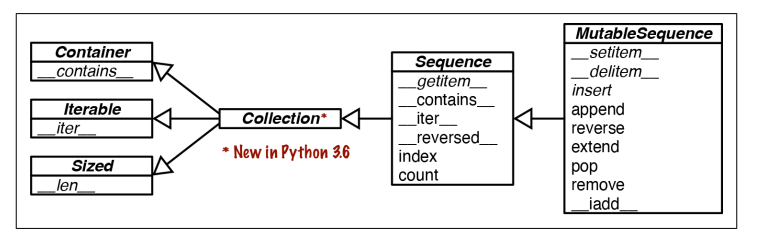

* The concrete methods in each collections.abc ABC are implemented in terms of the public interface of the class, so they work without any knowledge of the internal structure of instances.

* You may be able to override methods inherited from ABCs with more efficient implementations. For example, `__contains__` works by doing a `sequential scan`of the sequence, but if your concrete sequence keeps its items sorted, you can write a faster `__contains__` that does a binary search using the `bisect` function from the standard library.

### ABCs in the Standard Library
* There are two modules named abc in the standard library. Here we are talking about `collections.abc`. To reduce loading time, since
Python 3.4 that module is implemented outside of the collections package.
* The other abc module is just abc where the `abc.ABC` class is defined. Every ABC depends on the abc module, but we don’t need to import it ourselves except to create a brand-new ABC.

`Figure 13-4` is a summary of 17 ABCs defined in `collections.abc`

![Screenshot 2023-12-14 164219.png](<attachment:Screenshot 2023-12-14 164219.png>).
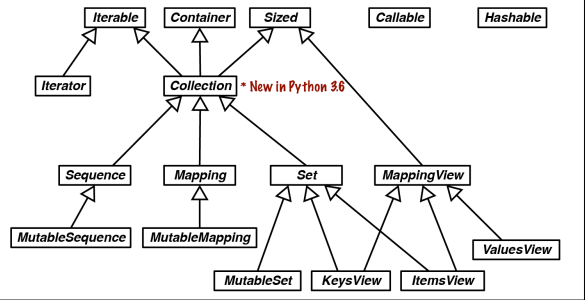

`diagram 13-4 review`

<br>`Iterable, Container, Sized`
-   Every collection should either inherit from these ABCs or implement compatible protocols. Iterable supports iteration with `__iter__`, Container supports the
in operator with `__contains__`, and Sized supports len() with `__len__`.

<br>`Collection`

-   This ABC has no methods of its own, but was added in Python 3.6 to make it easier to subclass from Iterable, Container, and Sized. 

<br>`Sequence, Mapping, Set`
-   These are the main immutable collection types, and each has a mutable subclass.

<br>`MappingView`
-   In Python 3, the objects returned from the mapping methods. items(), .keys(), and .values() implement the interfaces defined in ItemsView, KeysView, and ValuesView, respectively. The first two also implement the rich interface of Set, with all the operators we saw in “Set Operations” on page 107.

<br>`Iterator`
-   We discuss this further in Chapter 17

<br>`Callable, Hashable`
-   These are not collections, but collections.abc was the first package to define
ABCs in the standard library, and these two were deemed important enough
to be included. They support type checking objects that must be callable or
hashable.
-   For callable detection, the callable(obj) built-in function is more convenient than
insinstance(obj, Callable).

-   If insinstance(obj, Hashable) returns False, you can be certain that obj is not
hashable. But if the return is True, it may be a false positive.

### Defining and Using an ABC
* Note that ABCs are tools for building frameworks and are not to be used regularly.
* ABCs have more potential use cases in type hints to support static typing.Using ABCs instead of concrete types in function argument type hints gives more flexibility to the caller.


Here is an ABC implementation.
`Example 13-7` shows the definition of the Tombola ABC.

In [8]:
#Example 13-7. tombola.py: Tombola is an ABC with
# two abstract methods and two concrete methods

import abc

class Tombola(abc.ABC): 
    @abc.abstractmethod
    def load(self, iterable):
         """Add items from an iterable."""

    @abc.abstractmethod
    def pick(self):
        """
        Remove item at random, returning it.
        This method should raise `LookupError` when the instance is empty.
        """
    def loaded(self): 
        """Return `True` if there's at least 1 item, `False` otherwise."""
        return bool(self.inspect()) 
    
    def inspect(self):
        """Return a sorted tuple with the items currently inside."""
        items = []
        while True: 
            try:
                items.append(self.pick())
            except LookupError:
                break
        self.load(items) 
        return tuple(items)

* An abstract method can actually have an implementation. Even if it does, subclasses will still be forced to override it, but they will be able to invoke the abstract method with `super()`, adding functionality to it instead of implementing from scratch.

* `Example 13-7 `shows that we can rely on `.pick()` and `.load(…)` to inspect what’s inside the Tombola ABC.

* The `.loaded()` method in `Example 13-7` has one line, but it’s expensive: it calls `.inspect()` to build the tuple just to apply `bool()` on it. This works, but a concrete subclass can do much better work.

* Note that our roundabout implementation of `.inspect()` requires that we catch a `LookupError` thrown by `self.pick()`. The fact that `self.pick()` may raise `LookupError` is also part of its interface, but there is no way to make this explicit in Python, except in the documentation

* The point of this example is to highlight that it’s OK to provide concrete methods in ABCs, as long as they only depend on other methods in the interface.

* The `LookupError exception` because of its place in the Python hierarchy of exceptions in relation to `IndexError` and `KeyError`, the most likely exceptions to be raised by the data structures used to implement a concrete Tombola. Therefore, implementations can raise `LookupError`, `IndexError`, `KeyError`, or a custom subclass of LookupError to comply

To witness the interface checking performed by an ABC, we test tombola with a defective implementation in`Example 13-8`

In [ ]:
#Example 13-8. A fake Tombola doesn’t go undetected

class Fake(Tombola):
    def pick(self):
        return 13
    
f = Fake()

### ABC Syntax Details

* The standard way to declare an ABC is to subclass abc.ABC or any other ABC.

<br> the abc module defines the `ABC base class`, and the `@abstractmethod` decorator. You can  stack decorators on top of @abstractmethod as well

In [ ]:
#sample
class MyABC(abc.ABC):
    @classmethod
    @abc.abstractmethod
    def an_abstract_classmethod(cls, ):
        pass

* The order of stacked function decorators matters, and in the case of `@abstractmethod`, the documentation is explicit: 
    * When abstractmethod() is applied in combination with other method descriptors, it should be applied as the `innermost decorator`
    * In other words, no other decorator may appear between `@abstractmethod` and the `def statement`.

### Subclassing an ABC
we’ll now develop two concrete subclasses that satisfy its
interface. These classes were pictured in Figure 13-5, along with the virtual subclass
to be discussed in the next section.

In [ ]:
#Example 13-9. bingo.py: BingoCage is a concrete subclass of Tombola

import random
class BingoCage(Tombola):
    def __init__(self, items):
        self._randomizer = random.SystemRandom()
        self._items = []
        self.load(items)
    def load(self, items):
        self._items.extend(items)
        self._randomizer.shuffle(self._items)
    def pick(self):
        try:
            return self._items.pop()
        except IndexError:
            raise LookupError('pick from empty BingoCage')
    def __call__(self):
        self.pick()

* This BingoCage class explicitly extends Tombola.


* BingoCage inherits the expensive loaded and the inspect methods from Tombola.
*Both could be overridden with much faster one-liners.
* The point is: we can be lazy and just inherit the `suboptimal` concrete methods from an ABC.
* The methods inherited from Tombola are not as fast as they could be for BingoCage, but they do provide correct results for any Tombola subclass that correctly implements `pick` and `load`.

* `Example 13-10` shows a very different but equally valid implementation of the Tombola interface. Instead of shuffling the “balls” and popping the last, LottoBlower pops from a random position.

`Example 13-10`. lotto.py: LottoBlower is a concrete subclass that overrides the inspect and loaded methods from Tombola

In [ ]:
import random
class LottoBlower(Tombola):
    def __init__(self, iterable):
        self._balls = list(iterable)
    def load(self, iterable):
        self._balls.extend(iterable)
    def pick(self):
        try:
            position = random.randrange(len(self._balls))
        except ValueError:
            raise LookupError('pick from empty LottoBlower')
        return self._balls.pop(position)
    def loaded(self):
        return bool(self._balls)
    def inspect(self):
        return tuple(self._balls)


`Example 13-10` illustrates an idiom worth mentioning: in `__init__`, `self._balls` stores list(iterable) and not just a reference to iterable i.e., we did not merely assign `self._balls = iterable, aliasing the argument.` 

### A Virtual Subclass of an ABC
* An essential characteristic of goose typing
* one reason why it deserves a waterfowl name is the **ability to register a class as a virtual subclass of an ABC**
* we promise that the class faithfully implements the interface defined in the ABC and Python will believe us without checking.
* If we lie, we’ll be caught by the usual runtime exceptions.
* This is done by calling a register class method on the ABC. 
* The registered class then becomes `a virtual subclass` of the ABC, and will be recognized as such by `issubclass`, but it does not inherit any methods or attributes from the ABC.

* static type checkers can’t handle virtual subclasses at this time
* The register method is usually invoked as a plain function  but it can also be used as a decorator

In `Example 13-11`, we use the decorator syntax and implement TomboList, a virtual subclass of Tombola

In [17]:
#Example 13-11. tombolist.py: class TomboList is a virtual subclass of Tombola
from random import randrange
@Tombola.register
class TomboList(list):
    def pick(self):
        if self:
            position = randrange(len(self))
            return self.pop(position) 
        else:
            raise LookupError('pop from empty TomboList')
            load = list.extend
    def loaded(self):
        return bool(self)
    def inspect(self):
        return tuple(self)


Note that because of the registration, the functions `issubclass` and `isinstance` act as if TomboList is a subclass of Tombola:

In [18]:
issubclass(TomboList, Tombola)
True
t = TomboList(range(100))
isinstance(t, Tombola)
True

True

* However, inheritance is guided by a special class attribute named `__mro__` the `Method Resolution Order`.
* It basically lists the class and its superclasses in the order Python uses to search for methods.
* If you inspect the __mro__ of TomboList, you’ll see that it lists only the “real” superclasses—list and object

In [19]:
TomboList.__mro__

(__main__.TomboList, list, object)

### Usage of register in Practice

* Prior to Python 3.3, register could not be used as a decorator
* However even now widely it's more widely deployed as a function to register classes defined elsewhere

For example, in the source code for the `collections.abc` module, the built-in types tuple, str, range, and memoryview are registered as virtual subclasses of Sequence, like this:

In [ ]:
Sequence.register(tuple)
Sequence.register(str)
Sequence.register(range)
Sequence.register(memoryview)

* Several other built-in types are registered to ABCs in `collections_abc.py`. 
* Those registrations happen only when that module is imported, which is OK because you’ll have to import it anyway to get the ABCs
* Subclassing an ABC or registering with an ABC are both explicit ways of making our classes pass `issubclass` and`isinstance` checks

### Structural Typing with ABCs
* ABCs are mostly used with nominal typing.
* When a class Sub explicitly inherits from AnABC, or is registered with AnABC, the name of AnABC is linked to the Sub class—and
that’s how at runtime, issubclass(AnABC, Sub) returns True.
* structural typing is about looking at the structure of an object’s public interface to determine its type

* an object is consistent-with a type if it implements the
methods defined in the type.

* `Dynamic` and `static` `duck typing` are two approaches to
`structural typing`


a class can be recognized as a subclass of an ABC even without registration.
<br>here is an example

In [ ]:
class Struggle:
    def __len__(self): return 23

from collections import abc
isinstance(Struggle(), abc.Sized)
True
issubclass(Struggle, abc.Sized)
True

* It is true because abc.Sized implements a special
class method named `__subclasshook__`.
* The `__subclasshook__` for Sized checks whether the class argument has an attribute named `__len__`. 
If it does, then it is considered a virtual subclass of Sized.

In [ ]:
#Example 13-12. Definition of Sized from the source code of Lib/_collections_abc.py

class Sized(metaclass=ABCMeta):
    __slots__ = ()

    @abstractmethod
    def __len__(self):
        return 0
    
    @classmethod
    def __subclasshook__(cls, C):
        if cls is Sized:
            if any("__len__" in B.__dict__ for B in C.__mro__):
                return True
        return NotImplemented

* That’s how `__subclasshook__` allows ABCs to support structural typing. You can
formalize an interface with an ABC, you can make `isinstance` checks against that ABC, and still have a completely unrelated class pass an issubclass check because it implements a certain method (or because it does whatever it takes to convince a
`__subclasshook__` to vouch for it).

* All the implementations of `__subclasshook__` in the Python source code, are in ABCs like Sized that declare just `one special method`, and they simply check for that special method name.so you can be pretty sure that any method named `__len__` does what you expect.
* But even in the realm of special methods and fundamental ABCs, it can be risky to make such assumptions. For example, mappings implement `__len__`, `__getitem__`, and `__iter__`, but they are rightly not considered subtypes of Sequence, because you can’t retrieve items using
integer offsets or slices. That’s why the abc.Sequence class does not implement `__subclasshook__`.

* For ABCs that you and I may write, a `__subclasshook__` would be even less dependable.
<Br>It’s better to let the programmer affirm it by subclassing Spam from Tombola, or registering it with Tombola.register(Spam).

### Static Protocols
* how a static protocol makes it possible to annotate and type check the double() function?

### The Typed double Function
* Before static protocols were introduced, there was no practical way to add type hints to double without limiting its possible uses.

* with `typing.Protocol` we can tell Mypy that double takes an argument x that supports x * 2. `Example 13-13` shows how.

In [ ]:
#Example 13-13. double_protocol.py: definition of double using a Protocol
from typing import TypeVar, Protocol
T = TypeVar('T')
class Repeatable(Protocol):
    def __mul__(self: T, repeat_count: int) -> T: ...
RT = TypeVar('RT', bound=Repeatable)
def double(x: RT) -> RT:
        return x * 2

* The nominal type of the actual argument x given to double is irrelevant as long as it quacks, that is, as long as it implements `__mul__`.

### Runtime Checkable Static Protocols
* typing.Protocol appears in the static checking
area.
* However, when defining a `typing.Protocol`
subclass, you can use the `@runtime_checkable decorator` to make that protocol support `isinstance/issubclass` checks at runtime

* This works because typing.Protocol is an ABC, therefore it supports the `__subclasshook__`. 

* Python 3.9, the typing module includes seven ready-to-use protocols that are runtime checkable. Here are two of them:

* class typing.SupportsComplex An ABC with one abstract method, __complex__.

* class typing.SupportsFloat An ABC with one abstract method, __float__.

* These protocols are designed to check numeric types for `“convertibility”`

* the __complex__ special method exists to support the complex() built-in function.

`Example 13-14` shows the source code for the typing.SupportsComplex protocol.

In [ ]:
#Example 13-14. typing.SupportsComplex protocol source code

@runtime_checkable
class SupportsComplex(Protocol):
    """An ABC with one abstract method __complex__."""
    __slots__ = ()
    @abstractmethod
    def __complex__(self) -> complex:
        pass

* During static type checking, an object will be considered consistent-with the SupportsComplex protocol if it implements a
`__complex__` method that takes only self and returns a complex

Thanks to the `@runtime_checkable` class decorator applied to `SupportsComplex`, that
protocol can also be used with isinstance checks in `Example 13-15`.

In [22]:
#Example 13-15. Using SupportsComplex at runtime
from typing import SupportsComplex
import numpy as np

c64 = np.complex64(3+4j)

#isinstance(c64, complex)
False

#isinstance(c64, SupportsComplex)
True
#c = complex(c64)

#c
(3+4j)

#isinstance(c, SupportsComplex)
False

complex(c)
(3+4j)


(3+4j)

As a result of that last point, if you want to test whether an object c is a `complex` or `SupportsComplex`, you can provide a tuple of types as the second argument to
`isinstance`, like this:

In [23]:
isinstance(c, (complex, SupportsComplex))

True

An alternative would be to use the `Complex ABC`, defined in the numbers module.
The built-in complex type and the NumPy complex64 and complex128 types are all registered as `virtual subclasses of numbers.Complex`, therefore this works:

In [24]:
import numbers
isinstance(c, numbers.Complex)
True
isinstance(c64, numbers.Complex)
True

True

* **when you write an if statement where the condition is  <BR>`isinstance(o, MyType)` then Mypy can infer that inside the if block, the type of the o object is consistent-with
MyType.**

* Very often at runtime, duck typing is the best approach for type checking: instead of
calling `isinstance` or `hasattr`

given an object o that I need to use as a complex number, this would be one approach:

In [ ]:
if isinstance(o, (complex, SupportsComplex)):
    # do something that requires `o` to be convertible to complex
else:
    raise TypeError('o must be convertible to complex')

However, I prefer to leverage duck typing and do this using the EAFP principle
**it’s easier to ask for forgiveness than permission**

In [ ]:
try:
 c = complex(o)
except TypeError as exc:
    raise TypeError('o must be convertible to complex') from exc

### Limitations of Runtime Protocol Checks

* We’ve seen that type hints are generally ignored at runtime, and this also affects the use of `isinstance` or `issubclass` checks against static protocols.

* For example, any class with a `__float__` method is considered—at runtime—a vir‐
tual subclass of SupportsFloat, even if the `__float__` method does not return a
float.



In [29]:
import sys

sys.version

c = 3+4j
c.__float__


AttributeError: 'complex' object has no attribute '__float__'

* In Python 3.9, the complex type does have a `__float__` method, but it exists only to
raise a TypeError with an explicit error message. If that `__float__` method had
annotations, the return type would be `NoReturn`


But type hinting complex.__float__ on typeshed would not solve this problem
because Python’s runtime generally ignores type hints—and can’t access the typeshed
stub files anyway.

In [30]:
from typing import SupportsFloat
c = 3+4j
isinstance(c, SupportsFloat)


issubclass(complex, SupportsFloat)



False

* **The specific isssue with the complex type is fixed in Python
3.10.0b4 with the removal of the complex.`__float__` method.
But the overall issue remains: isinstance/issubclass checks only
look at the presence or absence of methods, without checking their
signatures, much less their type annotations. And this is not about
to change, because such type checks at runtime would have an
unacceptable performance cost**

### Supporting a Static Protocol
* Given that a complex number and a Vector2d instance both consist of a pair of floats, it makes sense to support conversion from `Vector2d` to `complex`.

`Example 13-16` shows the implementation of the `__complex__` method to enhance
the last version of Vector2d we saw in `Example 11-11`.
<br> For completeness, we can support the inverse operation with a fromcomplex class method to build a Vector2d from a complex.

In [ ]:
def __complex__(self):
    return complex(self.x, self.y)
@classmethod
def fromcomplex(cls, datum):
    return cls(datum.real, datum.imag) 

* This assumes that datum has `.real` and `.imag` attributes. We’ll see a better implementation in `Example 13-17`.

Given the preceding code, and the `__abs__` method the Vector2d already had in `Example 11-11`, we get these features:

In [ ]:
from typing import SupportsComplex, SupportsAbs
from vector2d_v4 import Vector2d

v = Vector2d(3, 4)
isinstance(v, SupportsComplex)
#True
isinstance(v, SupportsAbs)
#True

complex(v)
#(3+4j)

abs(v)
#5.0

Vector2d.fromcomplex(3+4j)
Vector2d(3.0, 4.0)

For runtime type checking, `Example 13-16` is fine, but for better static coverage and error reporting with Mypy, the `__abs__`, `__complex__`, and `fromcomplex methods`
should get type hints, as shown in `Example 13-17`.

In [ ]:
#Example 13-17. vector2d_v5.py: adding annotations to the methods under study
def __abs__(self) -> float:
    return math.hypot(self.x, self.y)

def __complex__(self) -> complex:
    return complex(self.x, self.y)

@classmethod
def fromcomplex(cls, datum: SupportsComplex) -> Vector2d:
    c = complex(datum)
    return cls(c.real, c.imag)

* That import causes type hints to be stored as strings, without being evaluated at import time, when function definitions are
evaluated. 
* Without the `__future__` import of annotations, Vector2d is an invalid reference at this point (the class is not fully defined yet) and should be written as a
string: 'Vector2d', as if it were a forward reference.

### Designing a Static Protocol

* `single-method protocols` make static duck typing more useful and flexible

<br>Using a container that picks items at random may or may not require reloading the
container, but it certainly needs a method to do the actual pick, so that’s the method I will choose for the minimal RandomPicker protocol.

In [32]:
#Example 13-18. randompick.py: definition of RandomPicker
from typing import Protocol, runtime_checkable, Any
@runtime_checkable
class RandomPicker(Protocol):
 def pick(self) -> Any: ...


In [34]:
#Example 13-19. randompick_test.py: RandomPicker in use
import random
from typing import Any, Iterable, TYPE_CHECKING

class SimplePicker:
    def __init__(self, items: Iterable) -> None:
        self._items = list(items)
        random.shuffle(self._items)
    def pick(self) -> Any:
        return self._items.pop()
    def test_isinstance() -> None:
        popper: RandomPicker = SimplePicker([1])
        assert isinstance(popper, RandomPicker)

    def test_item_type() -> None:
        items = [1, 2]
        popper = SimplePicker(items)
        item = popper.pick()
        assert item in items
        if TYPE_CHECKING:
            reveal_type(item)
        assert isinstance(item, int)

Both tests in `Example 13-19` pass. Mypy does not see any errors in that code either,
and shows the result of the reveal_type on the item returned by pick:

### Best Practices for Protocol Design

* After 10 years of experience with static duck typing in Go, it is clear that `narrow protocols` are more useful—often such protocols have a single method, rarely more than a couple of methods.

* Also, sometimes you see a protocol defined near the function that uses it—that is, defined in `“client code”` instead of being defined in a library.
* This makes it easy to
create new types to call that function, which is good for `extensibility and testing with mocks.`

* The practices of `narrow protocols` and `client-code protocols` both avoid unnecessary
tight coupling, in line with `the Interface Segregation Principle`, which we can summarize as <br> **“Clients should not be forced to depend upon interfaces that they do not use.”**

-   Use plain names for protocols that represent a clear concept (e.g., Iterator,Container).

-   Use SupportsX for protocols that provide callable methods (e.g., SupportsInt, SupportsRead, SupportsReadSeek).21

-   Use HasX for protocols that have `readable` and/or `writable` attributes or `getter/setter methods` (e.g., HasItems, HasFileno)

### Go standard library naming convention:

-    for single method protocols, if the method name is a verb, append “-er” or “-or” to make it a noun.

=>  For example, instead of SupportsRead, have Reader.
more examples such as instead of SupportsRead, have Reader.

-   One good reason to create minimalistic protocols is the ability to extend them later, if
needed.

### Extending a Protocol

* When practice reveals that a protocol with more methods is useful, instead of adding methods to the original protocol, it’s better to derive a new protocol from it. 
<br> Extending a static protocol in Python has a few caveats, as `Example 13-20` shows =>


In [ ]:
#Example 13-20. randompickload.py: extending RandomPicker
from typing import Protocol, runtime_checkable

@runtime_checkable
class LoadableRandomPicker(RandomPicker, Protocol):
 def load(self, Iterable) -> None: ...

-   If you want the derived protocol to be runtime checkable, you must apply the decorator again—its behavior is `not inherited`

-  Every protocol must explicitly name `typing.Protocol` as one of its base classes in addition to the protocol we are extending. This is different from the way inheritance works in Python.

-  Back to “regular” object-oriented programming: we only need to declare the method that is new in this derived protocol. The pick method declaration is `inherited` from RandomPicker. 

### The numbers ABCs and Numeric Protocols
* the ABCs in the numbers package of the standard library work fine for runtime type checking.

* If you need to check for an integer, you can use `isinstance(x, numbers.Integral)` to accept `int`, `bool (which subclasses int)` or other integer types that are provided by external libraries that register their types as `virtual subclasses of the numbers ABCs`.

* For example, NumPy has 21 integer types—as well as several variations of floatingpoint types registered as numbers.Real, and complex numbers with various bit widths registered as `numbers.Complex.`

* Somewhat surprisingly, `decimal.Decimal` is not registered as a `virtual subclass of numbers.Real`. The reason is that, if you need the precision of Decimal in your program, then you want to be protected from accidental mixing of decimals with floating-point
numbers that are less precise.

* he numeric tower was not designed for static type checking.
* The root ABC `numbers.Number` has no methods, so if you declare x: Number, Mypy will not let you do arithmetic or call any methods on x.

* If the numbers ABCs are not supported, what are the options?
* `the typeshed project`. As part of the
Python standard library, the statistics module has a corresponding `statistics.pyi`
stub file with type hints for on `typeshed`. There you’ll find the following definitions,
which are used to annotate several functions:

In [ ]:
_Number = Union[float, Decimal, Fraction]
_NumberT = TypeVar('_NumberT', float, Decimal, Fraction)

* That approach is correct, but limited. 
* `It does not support numeric types outside of the standard library`, which the numbers ABCs do support at runtime
*  when the numeric types are registered as `virtual subclasses`

*The current trend is to recommend the numeric protocols provided by the typing
module, which we discussed earlier on in `Runtime Checkable Static Protocols` 

* at runtime, the numeric protocols may let you down.
* the complex type in Python 3.9 implements `__float__`, but the method exists only to raise TypeError with an
explicit message: `“can’t convert complex to float.”` It implements `__int__` as well, for the same reason.

* The presence of those methods makes `isinstance` return misleading results in Python 3.9.

* In Python 3.10, the methods of complex that unconditionally raised TypeError were removed.

* On the other hand, NumPy’s complex types implement `__float__` and `__int__`
methods that work, only issuing a warning when each of them is used for the first time:

In [38]:
import numpy as np
cd = np.cdouble(3+4j)
cd
#(3+4j)
float(cd)

C:\Users\Reihan\AppData\Local\Temp\ipykernel_13796\835290972.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  float(cd)


3.0

* The opposite problem also happens:
 `built-ins complex`, `float`, and `int`, and also
`numpy.float16` and `numpy.uint8` , don’t have a `__complex__` method, so `isinstance(x, SupportsComplex)` returns False for them.

* The NumPy complex types,
such as `np.complex64`, do implement `__complex__` to convert to a built-in complex.

<br>However, in practice, the `complex() built-in constructor` handles instances of all these types with no errors or warnings:

In [39]:
import numpy as np
from typing import SupportsComplex

sample = [1+0j, np.complex64(1+0j), 1.0, np.float16(1.0), 1, np.uint8(1)]
[isinstance(x, SupportsComplex) for x in sample]
#[False, True, False, False, False, False]



#[complex(x) for x in sample]
#[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]

[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]

* This shows that isinstance checks against SupportsComplex suggest that those conversions to complex would fail, but they all succeed.
* In the typing-sig mailing list,
Guido van Rossum pointed out that the built-in complex accepts a single argument, and that’s why those conversions work.

On the other hand, Mypy accepts arguments of all those six types in a call to a
`to_complex()` function defined like this:

In [40]:
def to_complex(n: SupportsComplex) -> complex:
 return complex(n)

* As I write this, NumPy has no type hints, so its number types are all Any.
* On the other hand, Mypy is somehow “aware” that the built-in int and float `can be converted to complex`, even though on typeshed only the built-in complex class has a `__complex__` method.

* the type hints PEP 484 eschews the numeric tower and implicitly
recommends that type checkers hardcode the subtype relationships among `built-in complex, float, and int`.
*  Mypy does that, and it also pragmatically accepts that int and float are consistent-with `SupportsComplex`, even though they don’t implement `__complex__`


* The numbers ABCs are fine for runtime type checking, but unsuitable for static
typing.
    * The numeric static protocols `SupportsComplex`, `SupportsFloat`, etc. work well for static typing, but are unreliable for runtime type checking when complexnumbers are involved.


### Lecturers

*   Reihane Heidari : [Linkedin](https://www.linkedin.com/in/reihane-heidari-90147b299?utm_source=share&utm_campaign=share_via&utm_content=profile&utm_medium=android_app)


### Reviewers

1.   Somayeh Pakdel, Review Date : 12-19-2023, [Linkedin](https://www.linkedin.com/in/somayeh-pakdelmoez-901439176/)
2. Mahya Asgarian, review date: 2023-11-30 [LinkedIn](https://www.linkedin.com/in/mahya-asgarian-9a7b13249)



Presentation Date : 12-22-2023